In [1]:
import torch
import torchaudio

# Set a random seed for reproducibility
torch.random.manual_seed(0)

# Check if CUDA (GPU) is available, otherwise use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# Print the PyTorch and torchaudio versions and the selected device
print(torch.__version__)
print(torchaudio.__version__)
print(device)


2.0.1+cu117
2.0.2+cu117
cuda


In [2]:
import IPython
import matplotlib.pyplot as plt

In [3]:
# Defining the set of symbols used for character-based encoding
symbols = "_-!'(),.:;? abcdefghijklmnopqrstuvwxyz"

# Creatiing a lookup dictionary for symbols
look_up = {s: i for i, s in enumerate(symbols)}

# Creating a set of symbols
symbols = set(symbols)

# Function to convert text to a sequence of indices based on symbols
def text_to_sequence(text):
    text = text.lower()
    return [look_up[s] for s in text if s in symbols]

# Example text and its encoded sequence
text = "Akua is going to school"
print(text_to_sequence(text))


[12, 22, 32, 12, 11, 20, 30, 11, 18, 26, 20, 25, 18, 11, 31, 26, 11, 30, 14, 19, 26, 26, 23]


In [4]:
# Initializing the processor for character-based encoding
processor = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH.get_text_processor()

# Processing the text using the text processor
text = "Akua is going to school"
processed, lengths = processor(text)

# Printing the processed data and lengths
print(processed)
print(lengths)

# Printing the corresponding tokens for the processed data
print([processor.tokens[i] for i in processed[0, : lengths[0]]])


tensor([[12, 22, 32, 12, 11, 20, 30, 11, 18, 26, 20, 25, 18, 11, 31, 26, 11, 30,
         14, 19, 26, 26, 23]])
tensor([23], dtype=torch.int32)
['a', 'k', 'u', 'a', ' ', 'i', 's', ' ', 'g', 'o', 'i', 'n', 'g', ' ', 't', 'o', ' ', 's', 'c', 'h', 'o', 'o', 'l']


In [5]:
# Initializing the processor for phoneme-based encoding
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
processor = bundle.get_text_processor()

# Processing the text using the phoneme-based processor
text = "Akua is going to school"
with torch.inference_mode():
    processed, lengths = processor(text)

# Printing the processed data and lengths
print(processed)
print(lengths)

# Printing the corresponding tokens for the processed data
print([processor.tokens[i] for i in processed[0, : lengths[0]]])


tensor([[12, 64, 92, 20, 11, 55, 94, 11, 53, 69, 55, 68, 11, 81, 20, 11, 79, 64,
         87, 65]])
tensor([20], dtype=torch.int32)
['AA', 'K', 'W', 'AH', ' ', 'IH', 'Z', ' ', 'G', 'OW', 'IH', 'NG', ' ', 'T', 'AH', ' ', 'S', 'K', 'UW', 'L']


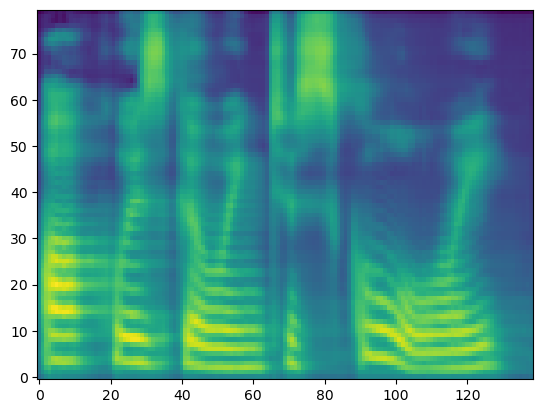

In [6]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)

text = "Akua is going to school"

# Setting a seed for reproducibility
torch.manual_seed(0)

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, _, _ = tacotron2.infer(processed, lengths)


_ = plt.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
plt.show()


In [7]:
def plot(save_path=None):
    # Creating subplots for displaying spectrogram data
    fig, ax = plt.subplots(3, 1)
    spectrogram_data = []  # Storing spectrogram data
    
    for i in range(3):
        with torch.inference_mode():
            # Generating spectrogram data using the Tacotron2 model
            spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
        
        # Appending spectrogram data to the list
        spectrogram_data.append(spec[0].cpu().detach())
        
        # Displaying the spectrogram as an image
        ax[i].imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
        
    # Saving the plot as an image if save_path is provided
    if save_path:
        plt.savefig(save_path, format='png')
    
    # Showing the plot
    plt.show()
    
    # Returning the spectrogram data
    return spectrogram_data


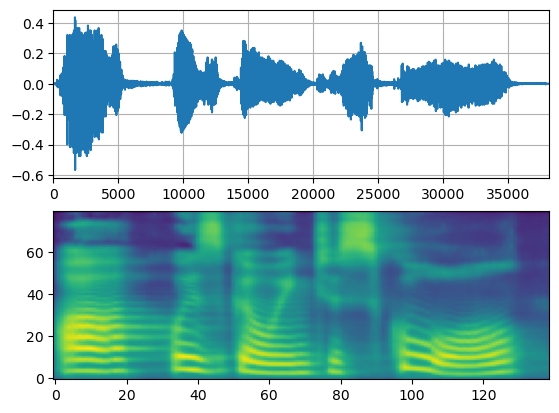

In [12]:
# Defining the TACOTRON2_WAVERNN_PHONE_LJSPEECH pipeline bundle
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

# Getting the text processing component from the bundle
processor = bundle.get_text_processor()


tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

# Defining the input text that you want to convert to speech
text = "Akua is going to school"

# Enabling inference mode (disabling gradient tracking for better performance)
with torch.inference_mode():
    # Processing the input text using the text processor, which tokenizes and encodes it
    processed, lengths = processor(text)
    processed = processed.to(device)  # Moving processed data to the specified device (e.g., GPU)
    lengths = lengths.to(device)  # Moving lengths to the specified device (e.g., GPU)
    
    # Generating spectrogram data using the Tacotron2 model
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
    
    # Synthesizing waveforms from the spectrogram using the Vocoder model
    waveforms, lengths = vocoder(spec, spec_lengths)

def plot(waveforms, spec, sample_rate):
    waveforms = waveforms.cpu().detach()

    # Creating subplots for displaying waveforms and spectrogram
    fig, [ax1, ax2] = plt.subplots(2, 1)
    
    # Plotting waveforms
    ax1.plot(waveforms[0])
    ax1.set_xlim(0, waveforms.size(-1))
    ax1.grid(True)
    
    # Displaying the spectrogram as an image
    ax2.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
    
    # Creating an audio widget for playback
    return IPython.display.Audio(waveforms[0:1], rate=sample_rate)

# Calling the plot function to display waveforms and spectrogram with audio playback
plot(waveforms, spec, vocoder.sample_rate)


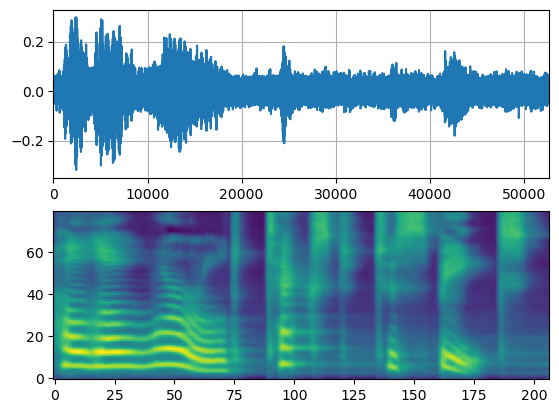

In [9]:
# Load the TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH processing bundle.
bundle = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
waveforms, lengths = vocoder(spec, spec_lengths)

plot(waveforms, spec, vocoder.sample_rate) 

Using cache found in C:\Users\Bernadette/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
C:\Users\Bernadette/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
C:\Users\Bernadette/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


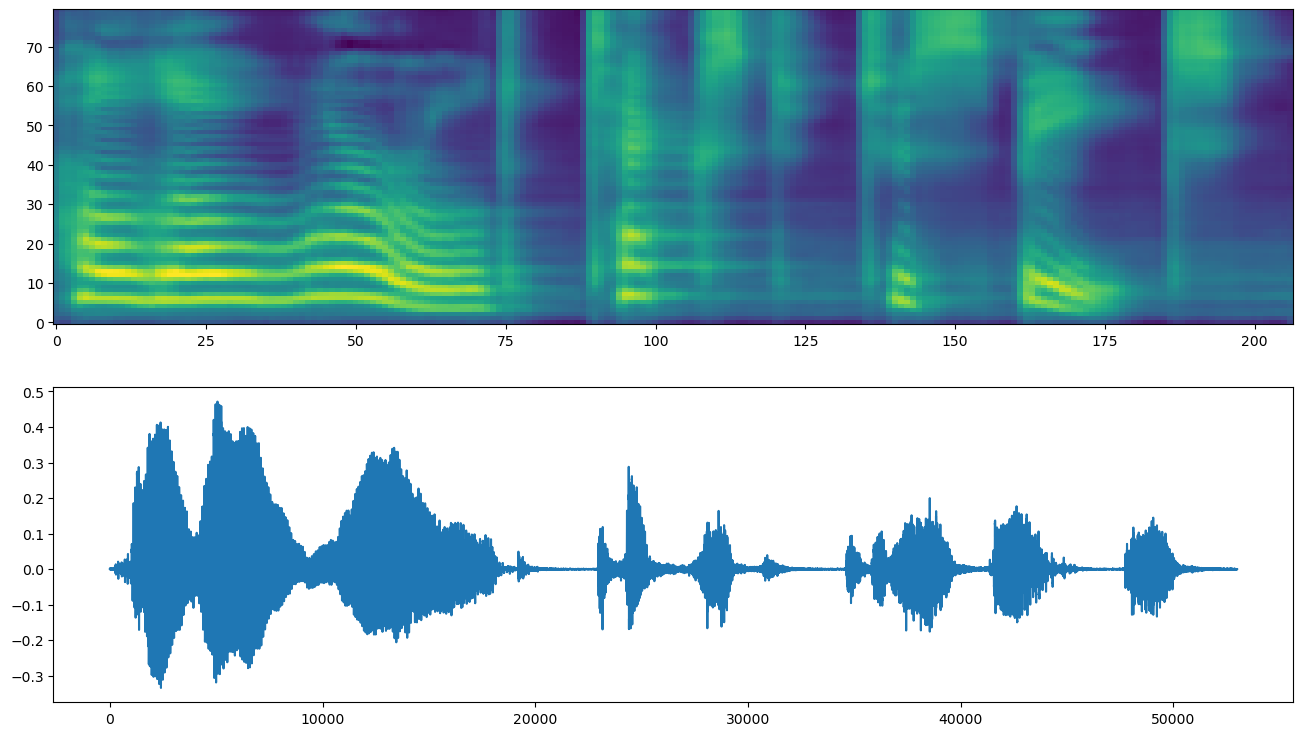

In [10]:
waveglow = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub",
    "nvidia_waveglow",
    model_math="fp32",
    pretrained=False,
)
checkpoint = torch.hub.load_state_dict_from_url(
    "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth",  # noqa: E501
    progress=False,
    map_location=device,
)
state_dict = {key.replace("module.", ""): value for key, value in checkpoint["state_dict"].items()}

waveglow.load_state_dict(state_dict)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()

with torch.no_grad():
    waveforms = waveglow.infer(spec)

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9))
ax1.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
ax2.plot(waveforms[0].cpu().detach())

IPython.display.Audio(waveforms[0:1].cpu(), rate=22050)

In [11]:
import torch
import torchaudio
import gradio as gr
import IPython

# Define the set of symbols used for character-based encoding
symbols = "_-!'(),.:;? abcdefghijklmnopqrstuvwxyz"

# Create a lookup dictionary for symbols
look_up = {s: i for i, s in enumerate(symbols)}

# Create a set of symbols
symbols = set(symbols)

# Function to convert text to a sequence of indices based on symbols
def text_to_sequence(text):
    text = text.lower()
    return [look_up[s] for s in text if s in symbols]

# Initialize the processor for character-based encoding
processor_char = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH.get_text_processor()

# Initialize the processor for phoneme-based encoding
processor_phone = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH.get_text_processor()
bundle_phone = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
tacotron2_phone = bundle_phone.get_tacotron2().to(device)
vocoder_phone = bundle_phone.get_vocoder().to(device)

# Load the WaveGlow model
waveglow = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub",
    "nvidia_waveglow",
    model_math="fp32",
    pretrained=False,
)
checkpoint = torch.hub.load_state_dict_from_url(
    "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth",
    progress=False,
    map_location=device,
)
state_dict = {key.replace("module.", ""): value for key, value in checkpoint["state_dict"].items()}
waveglow.load_state_dict(state_dict)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()

# Define a function that takes input and returns output
def text_to_speech(input_text, selected_model):
    if selected_model == "WaveRNN":
        processed, lengths = processor_char(input_text)
        with torch.inference_mode():
            processed = processed.to(device)
            lengths = lengths.to(device)
            spec, _, _ = tacotron2_phone.infer(processed, lengths)
            with torch.no_grad():
                waveform = waveglow.infer(spec)
        return waveform[0].cpu().numpy(), waveglow.sample_rate
    elif selected_model == "Griffin-Lim":
        processed, lengths = processor_char(input_text)
        with torch.inference_mode():
            processed = processed.to(device)
            lengths = lengths.to(device)
            spec, _, _ = tacotron2_phone.infer(processed, lengths)
            waveforms, lengths = vocoder_phone(spec)
        return waveforms[0].cpu().numpy(), vocoder_phone.sample_rate
    elif selected_model == "WaveGlow":
        processed, lengths = processor_char(input_text)
        with torch.inference_mode():
            processed = processed.to(device)
            lengths = lengths.to(device)
            spec, _, _ = tacotron2_phone.infer(processed, lengths)
            with torch.no_grad():
                waveforms = waveglow.infer(spec)
        return waveforms[0].cpu().numpy(), waveglow.sample_rate

# Define the input and output components for the Gradio interface
text_input = gr.Textbox(label="Enter Text", placeholder="Type here...")
model_choice = gr.Radio(["WaveRNN", "Griffin-Lim", "WaveGlow"], label="Select Model")


# Define the Gradio interface with the function as 'fn'
iface = gr.Interface(
    fn=text_to_speech,
    inputs=[text_input, model_choice],
    outputs=gr.outputs.Audio(type="file"),  # Use "file" as the output type
    title="Text-to-Speech",
    description="Convert text to speech using different models.",
)

# Launch the Gradio interface
iface.launch()



Using cache found in C:\Users\Bernadette/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
c:\Anaconda\lib\site-packages\gradio\outputs.py:80: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(


IMPORTANT: You are using gradio version 3.11.0, however version 3.14.0 is available, please upgrade.
--------
Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
